In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom
from scipy.stats import norm, geom

## Step 1. Generate example data

Assumptions

* Test scores are dispered on the scale of 0 - 100. Let's use a beta-binomial distribution for this. The parameter choice (a, b) = (4, 4) seems to produce a realistic looking distribution of test scores.
* Passing threshold is 20, and scores that would fall under this threshold are brough back to a low passing value, greater than 20, but not much greater.
* Let's assume an exponential distribution for this, with a minimum of 20, and a scale of 2.0


In [2]:
np.random.seed(123456)

students = 1000
true_scores = betabinom.rvs(100, 4, 4, size=students)
corrected_scores = true_scores.copy()
threshold = 20
exponential_scale = 2
below_threshold = (corrected_scores < threshold)
corrected_scores[below_threshold] = threshold \
    + np.round(np.random.exponential(scale=exponential_scale, size=np.sum(below_threshold)))

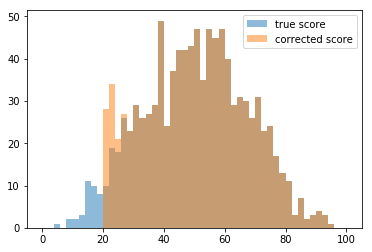

In [3]:
bins = np.linspace(0, 100, 51)
plt.hist(true_scores, bins=bins, alpha=0.5, label='true score')
plt.hist(corrected_scores, bins=bins, alpha=0.5, label='corrected score')
plt.legend()
plt.show()

One thousand students, the corrected score already shows a suspicious peak at 20. Next, we construct a Bayesian model to estimate the number of students that would have failed the test, should there be no corrections. Let's find the maximum likelihood estimate of the following two parameters:

1. Mean of true scores, mu
2. Standard deviation of true scores, sigma
3. Geometric distribution's probability p (This models the corrected scores)

## Step 2. Construct likelihood function
* x_true: true score
* x: observed score
* x0: threshold

Assuming a normal distribution for the true scores, the joint likelihood of mu, sigma, p is

    P(x | mu, sigma, p) = sum_{x_true} P(x, x_true| mu, sigma, p)
    
    = P(x| x_true >= x0, mu, sigma) * P(x_true >= x0) 
      + P(x | x_true < x0, p) * P(x_true < x0)
    
    = Normal(x | mu, sigma) * Heaviside(x - x0)
      + Geometric(x-x0 | p) * cdf_Normal(x0 | mu, sigma)

And the log likelihood

    log P (x | mu, sigma, s) = logsumexp([
        -1/2 * log(sigma^2) - (x - mu)^2 / (2*sigma^2),
        log(p) + (x - x0) * log(1-p) + log(1/2 * (1 + erf((x - mu) / (sqrt(2) * sigma)))
        ])

In [4]:
import torch

In [5]:
def logP(x, mu, sigma, s, x0):
    sigma_sq = sigma**2
    p = 0.5 * (1 + torch.tanh(s))
    div = x - mu
    normal_logterms = -0.5 * torch.log(sigma_sq) - div**2 / (2*sigma_sq)
    exp_logterms = torch.log(p) + (x - x0) * torch.log(1 - p) \
        + torch.log(0.5 * (1.0 + torch.erf((x0-mu) / torch.sqrt(2 * sigma_sq))))
    logterms = torch.stack((normal_logterms, exp_logterms))
    logP = torch.sum(torch.logsumexp(logterms, dim=0))
    return logP

In [6]:
mu = torch.tensor(50.0, requires_grad=True)
sigma = torch.tensor(25.0, requires_grad=True)
s = torch.tensor(0.0, requires_grad=True)
x = torch.tensor(corrected_scores, requires_grad=False)
x0 = torch.tensor(threshold, requires_grad=False)
optimizer = torch.optim.Adam([mu, sigma, s])
logP(x, mu, sigma, s, x0)

tensor(-3391.9138, grad_fn=<SumBackward0>)

## Step 3. Optimize the negative log likelihood

In [7]:
for i in range(20000):
    optimizer.zero_grad()
    mll = -logP(x, mu, sigma, s, x0)
    mll.backward()
    optimizer.step()

In [8]:
mu, sigma, 0.5 * (1 + torch.tanh(s)), logP(x, mu, sigma, s, x0)

(tensor(49.9641, requires_grad=True),
 tensor(17.0559, requires_grad=True),
 tensor(0.3397, grad_fn=<MulBackward0>),
 tensor(-3281.2698, grad_fn=<SumBackward0>))

## Step 4. Plot and summarize the results

Let's plot the fitted PDFs on top of the data

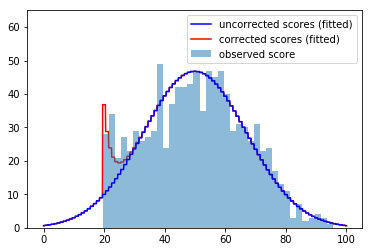

In [9]:
bins = np.linspace(0, 100, 51) -0.5
plt.hist(corrected_scores, bins=bins, alpha=0.5, label='observed score')
x_draw = np.linspace(0, 100, 1000)
b = bins[1] - bins[0]
N = len(corrected_scores)
p1 = norm.pdf(np.round(x_draw), loc=float(mu), scale=float(sigma))
p2 = geom.pmf(np.round(x_draw).astype(int), float(0.5 * (1 + torch.tanh(s))), loc=float(x0-1))  \
         * norm.cdf(float(x0), loc=float(mu), scale=float(sigma))
plt.plot(x_draw, N*b * p1, 
         'b-', label='uncorrected scores (fitted)')
plt.plot(x_draw, 
         N*b * (p1 + p2),
        'r-', label='corrected scores (fitted)', zorder=-1)
plt.legend(loc=1)
plt.ylim([0, 65])
plt.show()

And compute the fraction of of tests the scores of which was corrected.

In [10]:
norm.cdf(float(x0), loc=float(mu), scale=float(sigma))

0.03947388461870064